# Project: Build a Traffic Sign Recognition Classifier


In this notebook, I implemented a Trafic Sign Recognition Classifier using deep neural networks and convolutional neural networks to classify traffic signs. Specifically, I trained a model to classify traffic signs from the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

## Step 0: Load The Data


In [1]:
# Load pickled data
import pickle

traning_file = 'traffic-signs-data/train.p'
testing_file = 'traffic-signs-data/test.p'
validation_file = 'traffic-signs-data/valid.p'
sign_names_file = 'signnames.csv'

with open (traning_file, mode ='rb') as f:
    train = pickle.load(f)
    
with open (validation_file, mode ='rb') as f:
    valid = pickle.load(f)
    
with open (testing_file, mode ='rb') as f:
    test  = pickle.load(f)

with open(sign_names_file) as f:
    class_names = list(map( lambda x: x.strip().split(',')[1], f.readlines() ))
    class_names=class_names[1:] # strip header

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test , y_test  = test ['features'], test ['labels']

print("X_train shape:", X_train.shape, "    y_train shape:", y_train.shape)
print("X_valid shape:", X_valid.shape, "     y_valid shape:", y_valid.shape)
print("X_test shape:", X_test.shape, "     y_test shape:", y_test.shape)    


X_train shape: (34799, 32, 32, 3)     y_train shape: (34799,)
X_valid shape: (4410, 32, 32, 3)      y_valid shape: (4410,)
X_test shape: (12630, 32, 32, 3)      y_test shape: (12630,)


## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `features` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `labels` is a 1D array containing the label/class id of the traffic sign. The file signnames.csv contains id -> name mappings for each id.
- `sizes` is a list containing tuples, (width, height) representing the the original width and height the image.
- `coords` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image.


In [2]:
import numpy as np

n_train = len(X_train)
n_valid = len(X_valid)
n_test = len(X_test)
n_classes = np.size(np.unique(train['labels']))

image_shape = X_train[0].shape

print("Number of Trainig Examples = ", n_train)
print("Number of Validation Examples = ", n_valid)
print('Number of Testing Examples = ', n_test)
print("Number of Classes = ", n_classes)
print('image data shape', image_shape)


Number of Trainig Examples =  34799
Number of Validation Examples =  4410
Number of Testing Examples =  12630
Number of Classes =  43
image data shape (32, 32, 3)


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib examples](https://matplotlib.org/examples/index.html) and [gallery pages](https://matplotlib.org/gallery.html) are a great resource for doing visualizations in Python.

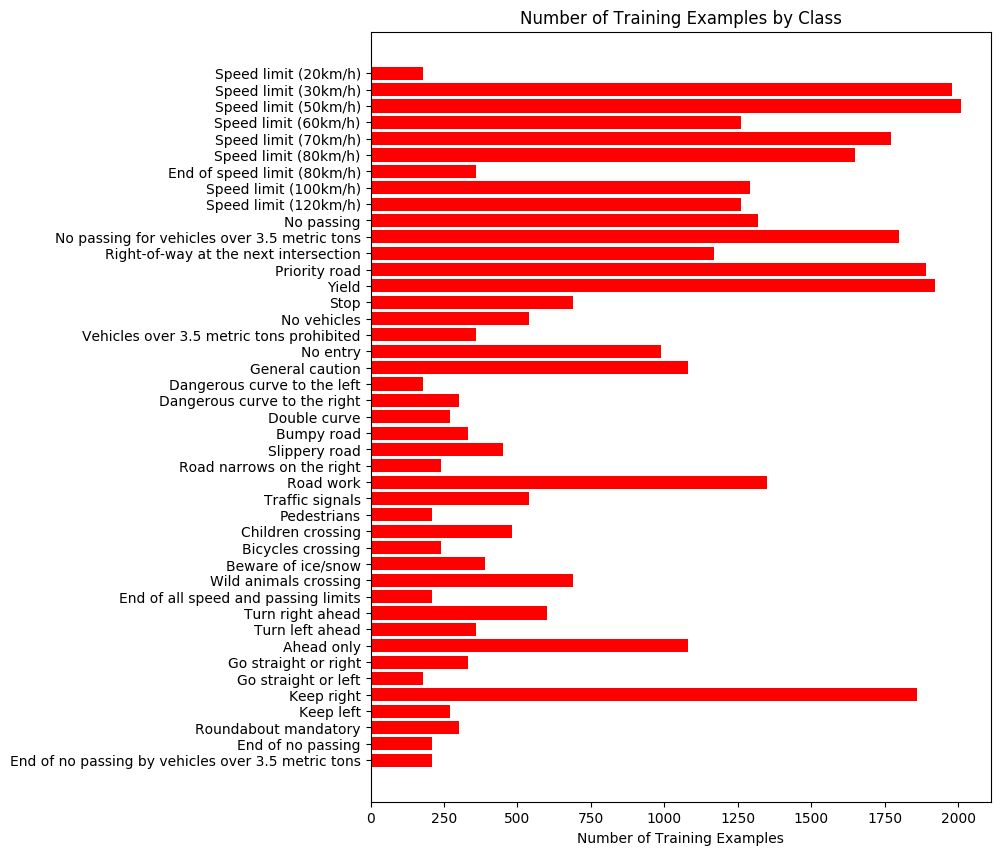

In [3]:
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

n_train_by_class =[]
for label, name in enumerate(class_names):
    n = sum(np.where(y_train == label, 1, 0))
    n_train_by_class.append(n)
plt.rcdefaults()

fig, ax = plt.subplots(figsize=(8, 10))

# Example data
y_pos = np.arange(n_classes)

ax.barh(y_pos, n_train_by_class,
        color='red', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(class_names)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Number of Training Examples')
ax.set_title('Number of Training Examples by Class')

plt.show()


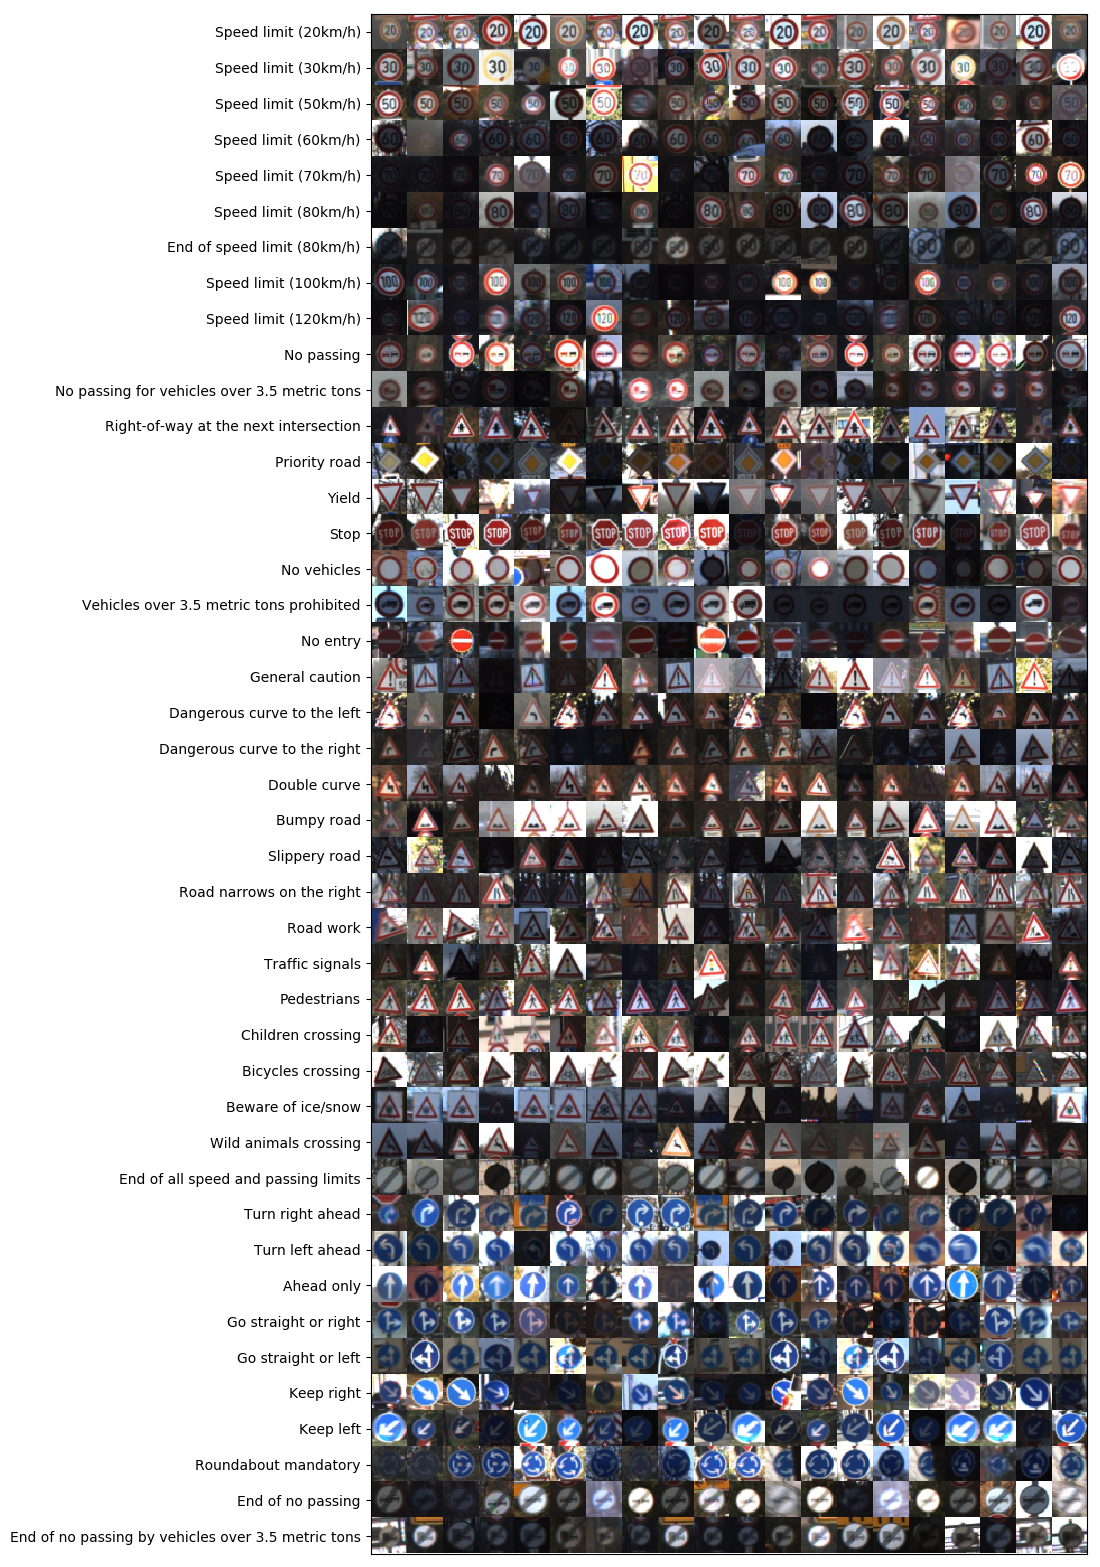

In [4]:
r=len(class_names)
c=20
plt.rcdefaults()

fig,ax = plt.subplots(figsize=(10,20))
examples=[]
for idx in range(r+1):
    if idx >= len(class_names):
        break
    cls_idx = np.argwhere(y_train==idx)
    np.random.shuffle(cls_idx)
    examples.append(np.hstack(X_train[cls_idx[0:c,0]]))
    
ax.imshow( np.vstack(examples))
ax.set_yticks(np.arange(n_classes)*image_shape[0]+image_shape[0]/2)
ax.set_yticklabels(class_names)
ax.set_xticks([])

plt.show()


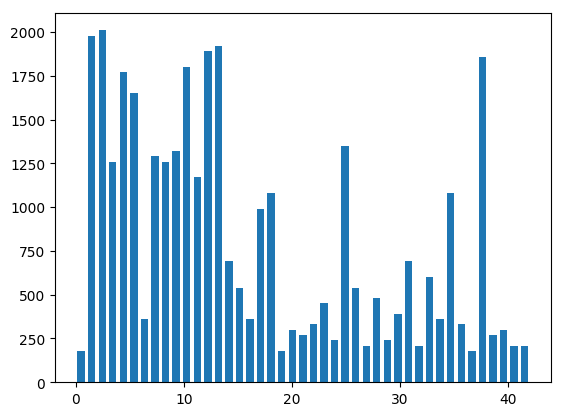

In [5]:
# histogram of label frequency
hist, bins = np.histogram(y_train, bins=n_classes)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)


#### Pre-process 1: *Augment training set*

(139196, 32, 32, 3) (139196,)


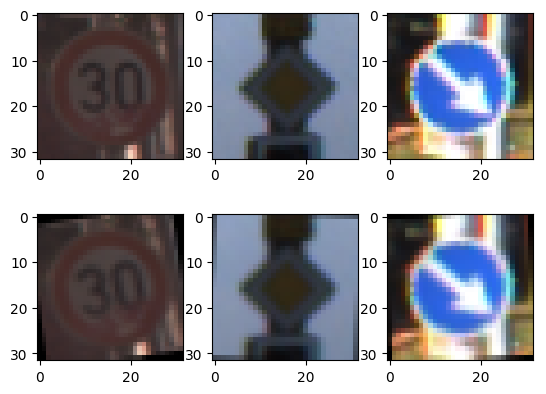

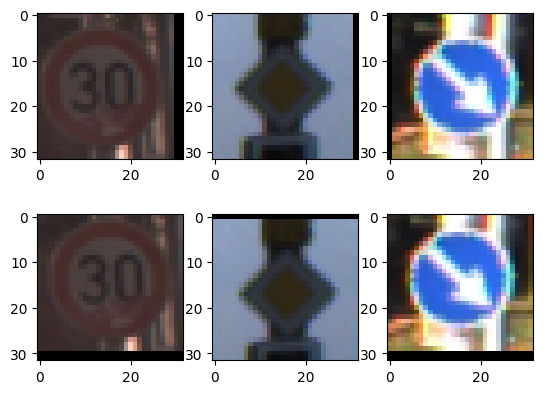

In [6]:
import random
import cv2

# Randomly rotate training set. ([-15, 15] angles)
rotated_train = {'features': [], 'labels': []}
for img, label in zip(train['features'], train['labels']):
    RotateMatrix = cv2.getRotationMatrix2D(center=(img.shape[1]/2, img.shape[0]/2), angle=random.uniform(-15, 15), scale=1)
    rotated_train['features'].append(cv2.warpAffine(img, RotateMatrix, (img.shape[0], img.shape[1])))
    rotated_train['labels'].append(label)
    

# Randomly perturbe training set in position. (on x/y axis, [-2,2] pixels)
perturbed_train = {'features': [], 'labels': []}
for img, label in zip(train['features'], train['labels']):
    pixel = random.sample([-2, -1, 1, 2], 1)[0]
    TranslationMatrix = np.array([[1, 0, pixel],
                                  [0, 1, 0]], dtype=np.float32)
    perturbed_train['features'].append(cv2.warpAffine(img, TranslationMatrix, (img.shape[0], img.shape[1])))
    perturbed_train['labels'].append(label)
    
    pixel = random.sample([-2, -1, 1, 2], 1)[0]
    TranslationMatrix = np.array([[1, 0, 0],
                                  [0, 1, pixel]], dtype=np.float32)
    perturbed_train['features'].append(cv2.warpAffine(img, TranslationMatrix, (img.shape[0], img.shape[1])))
    perturbed_train['labels'].append(label)

big_train = {
        'features':
            np.concatenate([train['features'], rotated_train['features'], perturbed_train['features']]),
        'labels':
            np.concatenate([train['labels'], rotated_train['labels'], perturbed_train['labels']])
    }

print(np.shape(big_train['features']), np.shape(big_train['labels']))

sample_idxes = random.sample(range(n_train), 3)

fig = plt.figure()
for i in range(3):
    ax = fig.add_subplot(2, 3, i+1)
    img = train['features'][sample_idxes[i],:,:,:]
    ax.imshow(img)
    
    RotateMatrix = cv2.getRotationMatrix2D(center=(img.shape[1]/2, img.shape[0]/2), angle=random.uniform(-15, 15), scale=1)
    rotated_img = cv2.warpAffine(img, RotateMatrix, (img.shape[0], img.shape[1]))
    ax = fig.add_subplot(2, 3, i+4)
    ax.imshow(rotated_img)

plt.show()

fig = plt.figure()
for i in range(3):
    img = train['features'][sample_idxes[i],:,:,:]
    pixel = random.sample([-2, -1, 1, 2], 1)[0]
    TranslationMatrix = np.array([[1, 0, pixel],
                                  [0, 1, 0]], dtype=np.float32)
    vertical_img = cv2.warpAffine(img, TranslationMatrix, (img.shape[0], img.shape[1]))
    ax = fig.add_subplot(2, 3, i+1)
    ax.imshow(vertical_img)
    
    pixel = random.sample([-2, -1, 1, 2], 1)[0]
    TranslationMatrix = np.array([[1, 0, 0],
                                  [0, 1, pixel]], dtype=np.float32)
    he_img = cv2.warpAffine(img, TranslationMatrix, (img.shape[0], img.shape[1]))
    ax = fig.add_subplot(2, 3, i+4)
    ax.imshow(he_img)
    
plt.show()

#### Pre-process2 : Grayscale

Converting to grayscale - This worked well for Sermanet and LeCun as described in their traffic sign classification article. It also helps to reduce training time, which was nice when a GPU wasn't available.

In [7]:
# Convert to grayscale
X_train_rgb = big_train['features']
X_train_gry = np.sum(X_train_rgb/3, axis=3, keepdims=True)

X_valid_rgb = valid['features']
X_valid_gry = np.sum(X_valid_rgb/3, axis=3, keepdims=True)

X_test_rgb = test['features']
X_test_gry = np.sum(X_test_rgb/3, axis=3, keepdims=True)

print('RGB shape:', X_train_rgb.shape)
print('Grayscale shape:', X_train_gry.shape)


RGB shape: (139196, 32, 32, 3)
Grayscale shape: (139196, 32, 32, 1)


#### Pre-process3 : Normalization

Normalizing the data to the range (-1,1) 

This was done using the line of code X_train_normalized = (X_train - 128)/128.
The resulting dataset mean wasn't exactly zero, but it was reduced from around 82 to roughly -0.35.
I chose to do this mostly because it was suggested in the lessons and it was fairly easy to do.
How it helps is a bit nebulous to me, but [this site](https://stats.stackexchange.com/questions/185853/why-do-we-need-to-normalize-the-images-before-we-put-them-into-cnn) has an explanation, the gist of which is that having a wider distribution in the data would make it more difficult to train using a singlar learning rate. Different features could encompass far different ranges and a single learning rate might make some weights diverge.

In [8]:
## Normalize the train, valid and test datasets to (-1,1)

X_train_normalized = (X_train_gry - 128)/128 
X_valid_normalized = (X_valid_gry - 128)/128
X_test_normalized  = (X_test_gry  - 128)/128

print(np.mean(X_train_normalized))
print(np.mean(X_valid_normalized))
print(np.mean(X_test_normalized))

-0.376953540481
-0.347215411128
-0.358215153428


#### Visualize rgb vs grayscale

Normalized shape: (139196, 32, 32, 1)                  Original shape: (34799, 32, 32, 3)


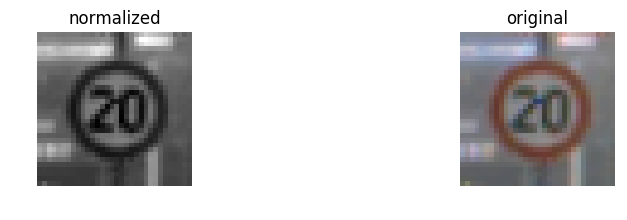

In [9]:
print("Normalized shape:", X_train_normalized.shape, "                 Original shape:", X_train.shape)
fig, axs = plt.subplots(1,2, figsize=(10, 2))
axs = axs.ravel()

axs[0].axis('off')
axs[0].set_title('normalized')
axs[0].imshow(X_train_normalized[10000].squeeze(), cmap='gray')

axs[1].axis('off')
axs[1].set_title('original')
axs[1].imshow(X_train[10000].squeeze(), cmap='gray')
plt.show()

#### Shuffle the training and validation dataset

In [10]:
from sklearn.utils import shuffle

X_train_normalized, y_train = shuffle(X_train_normalized, big_train['labels'])
X_valid_normalized, y_valid = shuffle(X_valid_normalized, y_valid)

print('done')


done


In [11]:
X_train = X_train_normalized
y_train = y_train

X_valid = X_valid_normalized
y_valid = y_valid

X_test  = X_test_normalized
y_test  = y_test


## Model Architecture

In [12]:
### Define your architecture here.
import tensorflow as tf
from tensorflow.contrib.layers import flatten

EPOCHS = 60
BATCH_SIZE = 128
rate = 0.001
mu = 0
sigma = 0.1
print('done')


done


### Modified LeNet Model Architecture

adapted from Sermanet/LeCunn traffic sign classification journal article

<img src='images/modifiedLeNet.jpeg' width='90%'/>

I began by implementing the same architecture from the LeNet Lab, with no changes since my dataset is in grayscale. This model worked quite well to begin with (~86% validation accuracy), but I also implemented the Sermanet/LeCun model from their traffic sign classifier paper and saw an immediate improvement. Although the paper doesn't go into detail describing exactly how the model is implemented (particularly the depth of the layers) I was able to make it work. The layers are set up like this:

- 5x5 convolution (32x32x1 in, 28x28x6 out)
- ReLU
- 2x2 max pool (28x28x6 in, 14x14x6 out)
- 5x5 convolution (14x14x6 in, 10x10x16 out)
- ReLU
- 2x2 max pool (10x10x16 in, 5x5x16 out)
- 5x5 convolution (5x5x6 in, 1x1x400 out)
- ReLu
- Flatten layers from numbers 8 (1x1x400 -> 400) and 6 (5x5x16 -> 400)
- Concatenate flattened layers to a single size-800 layer
- Dropout layer
- Fully connected layer (800 in, 43 out)

In [13]:
def LeNet2(x):    
   
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    W1 = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma), name="W1")
    x = tf.nn.conv2d(x, W1, strides=[1, 1, 1, 1], padding='VALID')
    b1 = tf.Variable(tf.zeros(6), name="b1")
    x = tf.nn.bias_add(x, b1)
    print("layer 1 shape:",x.get_shape())

    # relu Activation function for the firist layer.
    x = tf.nn.relu(x)
    
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    layer1 = x
    
    # Layer 2: Convolutional. Output = 10x10x16.
    W2 = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma), name="W2")
    x = tf.nn.conv2d(x, W2, strides=[1, 1, 1, 1], padding='VALID')
    b2 = tf.Variable(tf.zeros(16), name="b2")
    x = tf.nn.bias_add(x, b2)
                     
    # relu Activation function for the second layer.
    x = tf.nn.relu(x)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    layer2 = x

    # Layer 3: Convolutional. Output = 1x1x400.
    W3 = tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 400), mean = mu, stddev = sigma), name="W3")
    x = tf.nn.conv2d(x, W3, strides=[1, 1, 1, 1], padding='VALID')
    b3 = tf.Variable(tf.zeros(400), name="b3")
    x = tf.nn.bias_add(x, b3)
                     
    # relu Activation function for the thered layer.
    x = tf.nn.relu(x)
    
    layer3 = x

    # Flatten. Input = 5x5x16. Output = 400.
    layer2flat = flatten(layer2)
    print("layer2flat shape:",layer2flat.get_shape())
    
    # Flatten x. Input = 1x1x400. Output = 400.
    xflat = flatten(x)
    print("xflat shape:",xflat.get_shape())
    
    # Concat layer2flat and x. Input = 400 + 400. Output = 800
    x = tf.concat([xflat, layer2flat], 1)
    print("x shape:",x.get_shape())
    
    # Dropout
    tf.nn.dropout(x, keep_prob, noise_shape=None, seed=None, name=None)
    
    # Layer 4: Fully Connected. Input = 800. Output = 43.
    W4 = tf.Variable(tf.truncated_normal(shape=(800, 43), mean = mu, stddev = sigma), name="W4")
    b4 = tf.Variable(tf.zeros(43), name="b4")    
    logits = tf.add(tf.matmul(x, W4), b4)
    
    return logits

print('done')

done


In [14]:
tf.reset_default_graph() 

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, n_classes)

print('done')


done


### Train, Validate and Test the Model


A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation sets imply underfitting. A high accuracy on the test set but low accuracy on the validation set implies overfitting.

In [15]:
rate = 0.0009

logits = LeNet2(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

layer 1 shape: (?, 28, 28, 6)
layer2flat shape: (?, 400)
xflat shape: (?, 400)
x shape: (?, 800)


In [16]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

print('done')

done


In [17]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        XX_train, yy_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = XX_train[offset:end], yy_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
        training_accuracy = evaluate(X_train, y_train)
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Traning Accuracy = {:.3f}".format(training_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, 'lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Traning Accuracy = 0.955
Validation Accuracy = 0.898

EPOCH 2 ...
Traning Accuracy = 0.983
Validation Accuracy = 0.930

EPOCH 3 ...
Traning Accuracy = 0.986
Validation Accuracy = 0.931

EPOCH 4 ...
Traning Accuracy = 0.990
Validation Accuracy = 0.931

EPOCH 5 ...
Traning Accuracy = 0.993
Validation Accuracy = 0.938

EPOCH 6 ...
Traning Accuracy = 0.995
Validation Accuracy = 0.943

EPOCH 7 ...
Traning Accuracy = 0.996
Validation Accuracy = 0.944

EPOCH 8 ...
Traning Accuracy = 0.997
Validation Accuracy = 0.944

EPOCH 9 ...
Traning Accuracy = 0.998
Validation Accuracy = 0.945

EPOCH 10 ...
Traning Accuracy = 0.997
Validation Accuracy = 0.933

EPOCH 11 ...
Traning Accuracy = 0.999
Validation Accuracy = 0.948

EPOCH 12 ...
Traning Accuracy = 0.999
Validation Accuracy = 0.953

EPOCH 13 ...
Traning Accuracy = 0.997
Validation Accuracy = 0.938

EPOCH 14 ...
Traning Accuracy = 0.999
Validation Accuracy = 0.952

EPOCH 15 ...
Traning Accuracy = 0.996
Validation Accuracy 

In [18]:
# Now (drumroll) evaluate the accuracy of the model on the test dataset

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver2 = tf.train.import_meta_graph('./lenet.meta')
    saver2.restore(sess, "./lenet")
    test_accuracy = evaluate(X_test_normalized, y_test)
    print("Test Set Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet
Test Set Accuracy = 0.942


#### Hooray! 94.2% accuracy!

I used the Adam optimizer. The final settings used were:

- batch size: 128
- epochs: 60
- learning rate: 0.0009
- mu: 0
- sigma: 0.1
- dropout keep probability: 0.5

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.



### Load and Output the Images


In [19]:
# Reinitialize and re-import if starting a new kernel here
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import numpy as np
import cv2

print('done')

done


(8, 32, 32, 1)


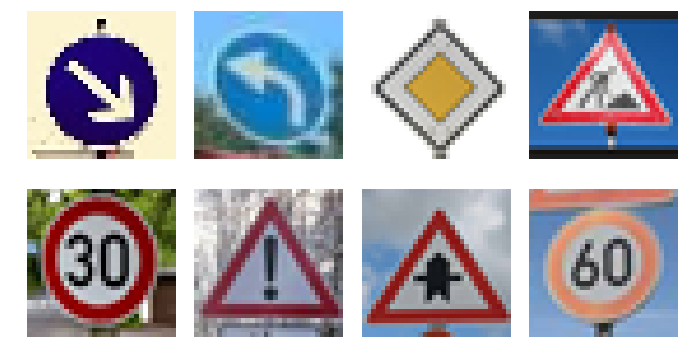

In [20]:
### Load the images and plot them here.

#reading in an image
import glob
import matplotlib.image as mpimg

fig, axs = plt.subplots(2,4, figsize=(12, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

my_images = []

for i, img in enumerate(glob.glob('./testing/*x.png')):
    image = cv2.imread(img)
    axs[i].axis('off')
    axs[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    my_images.append(image)

my_images = np.asarray(my_images)

my_images_gry = np.sum(my_images/3, axis=3, keepdims=True)

my_images_normalized = (my_images_gry - 128)/128 

print(my_images_normalized.shape)

In [21]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

my_labels = [38, 34, 12, 25, 1, 18, 11, 3]


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver3 = tf.train.import_meta_graph('./lenet.meta')
    saver3.restore(sess, "./lenet")
    my_accuracy = evaluate(my_images_normalized, my_labels)
    print("Test Set Accuracy = {:.3f}".format(my_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet
Test Set Accuracy = 1.000


The model appears to have predicted the new signs perfectly, with 100% accuracy - even better than the 96.0% validation accuracy and the 94.2% test accuracy. This is a good sign that the model performs well on real-world data. And while it's reasonable to assume that the accuracy would not remain so high given more data points, judging by the low fidelity of a number of images in the training dataset it's also reasonable to assume that if the real-world data were all as easily distinguishable as the eight images chosen that the accuracy would remain very high.

INFO:tensorflow:Restoring parameters from ./lenet


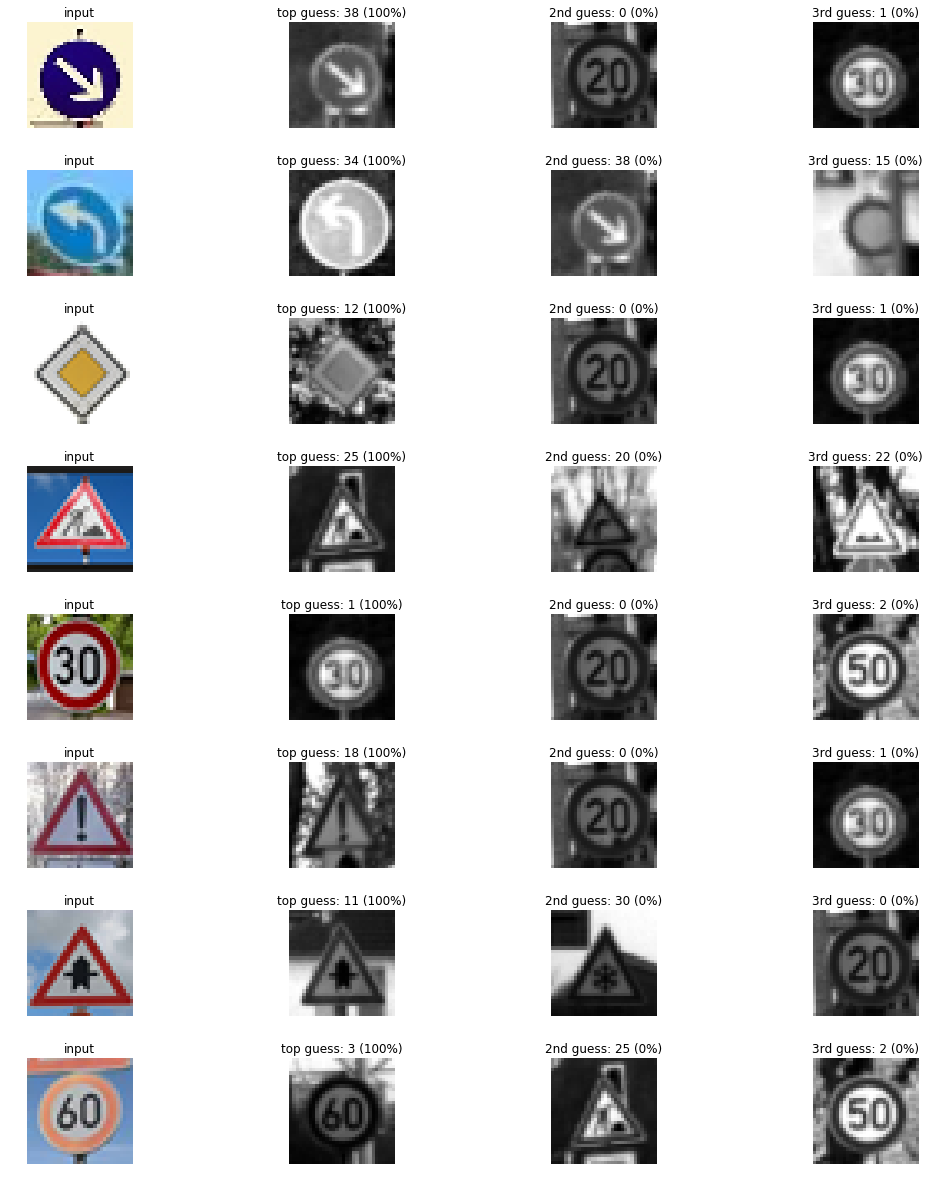

In [22]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

softmax_logits = tf.nn.softmax(logits)
top_k = tf.nn.top_k(softmax_logits, k=3)


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph('./lenet.meta')
    saver.restore(sess, "./lenet")
    my_softmax_logits = sess.run(softmax_logits, feed_dict={x: my_images_normalized, keep_prob: 1.0})
    my_top_k = sess.run(top_k, feed_dict={x: my_images_normalized, keep_prob: 1.0})

    
    fig, axs = plt.subplots(len(my_images),4, figsize=(18, 21))
    fig.subplots_adjust(hspace = .4, wspace=.2)
    axs = axs.ravel()

    for i, image in enumerate(my_images):
        axs[4*i].axis('off')
        axs[4*i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axs[4*i].set_title('input')
        guess1 = my_top_k[1][i][0]
        index1 = np.argwhere(y_valid == guess1)[0]
        axs[4*i+1].axis('off')
        axs[4*i+1].imshow(X_valid[index1].squeeze(), cmap='gray')
        axs[4*i+1].set_title('top guess: {} ({:.0f}%)'.format(guess1, 100*my_top_k[0][i][0]))
        guess2 = my_top_k[1][i][1]
        index2 = np.argwhere(y_valid == guess2)[0]
        axs[4*i+2].axis('off')
        axs[4*i+2].imshow(X_valid[index2].squeeze(), cmap='gray')
        axs[4*i+2].set_title('2nd guess: {} ({:.0f}%)'.format(guess2, 100*my_top_k[0][i][1]))
        guess3 = my_top_k[1][i][2]
        index3 = np.argwhere(y_valid == guess3)[0]
        axs[4*i+3].axis('off')
        axs[4*i+3].imshow(X_valid[index3].squeeze(), cmap='gray')
        axs[4*i+3].set_title('3rd guess: {} ({:.0f}%)'.format(guess3, 100*my_top_k[0][i][2]))

### Analyze Performance

According to the `signames.csv` file, the prediction result are as follows:

- The first image is predicted as "Keep right" sign. **Correct**
- The second image is predicted as "Turn left ahead" sign. **Correct**
- The third image is predicted as "Priority road" sign. **Correct**
- The fourth image is predicted as "Road work" sign. **Correct**
- The fifth image is predicted as "Speed limit (30km/h)" sign. **Correct**
- The sixth image is predicted as "General caution" sign. **Correct**
- The seventh image is predicted as "Right-of-way at the next intersection" sign. **Correct**
- The eighth image is predicted as "Speed limit (60km/h)" sign. **Correct**


So, the model predicted all of these signs correctly, it's 100% accurate on these new images.

In [23]:
print(my_top_k)

TopKV2(values=array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   9.00612990e-32,   3.84325261e-34],
       [  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   2.74864635e-22,   6.66015182e-35],
       [  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   1.36862265e-37,   0.00000000e+00],
       [  1.00000000e+00,   7.94981268e-12,   8.70952725e-22]], dtype=float32), indices=array([[38,  0,  1],
       [34, 38, 15],
       [12,  0,  1],
       [25, 20, 22],
       [ 1,  0,  2],
       [18,  0,  1],
       [11, 30,  0],
       [ 3, 25,  2]], dtype=int32))


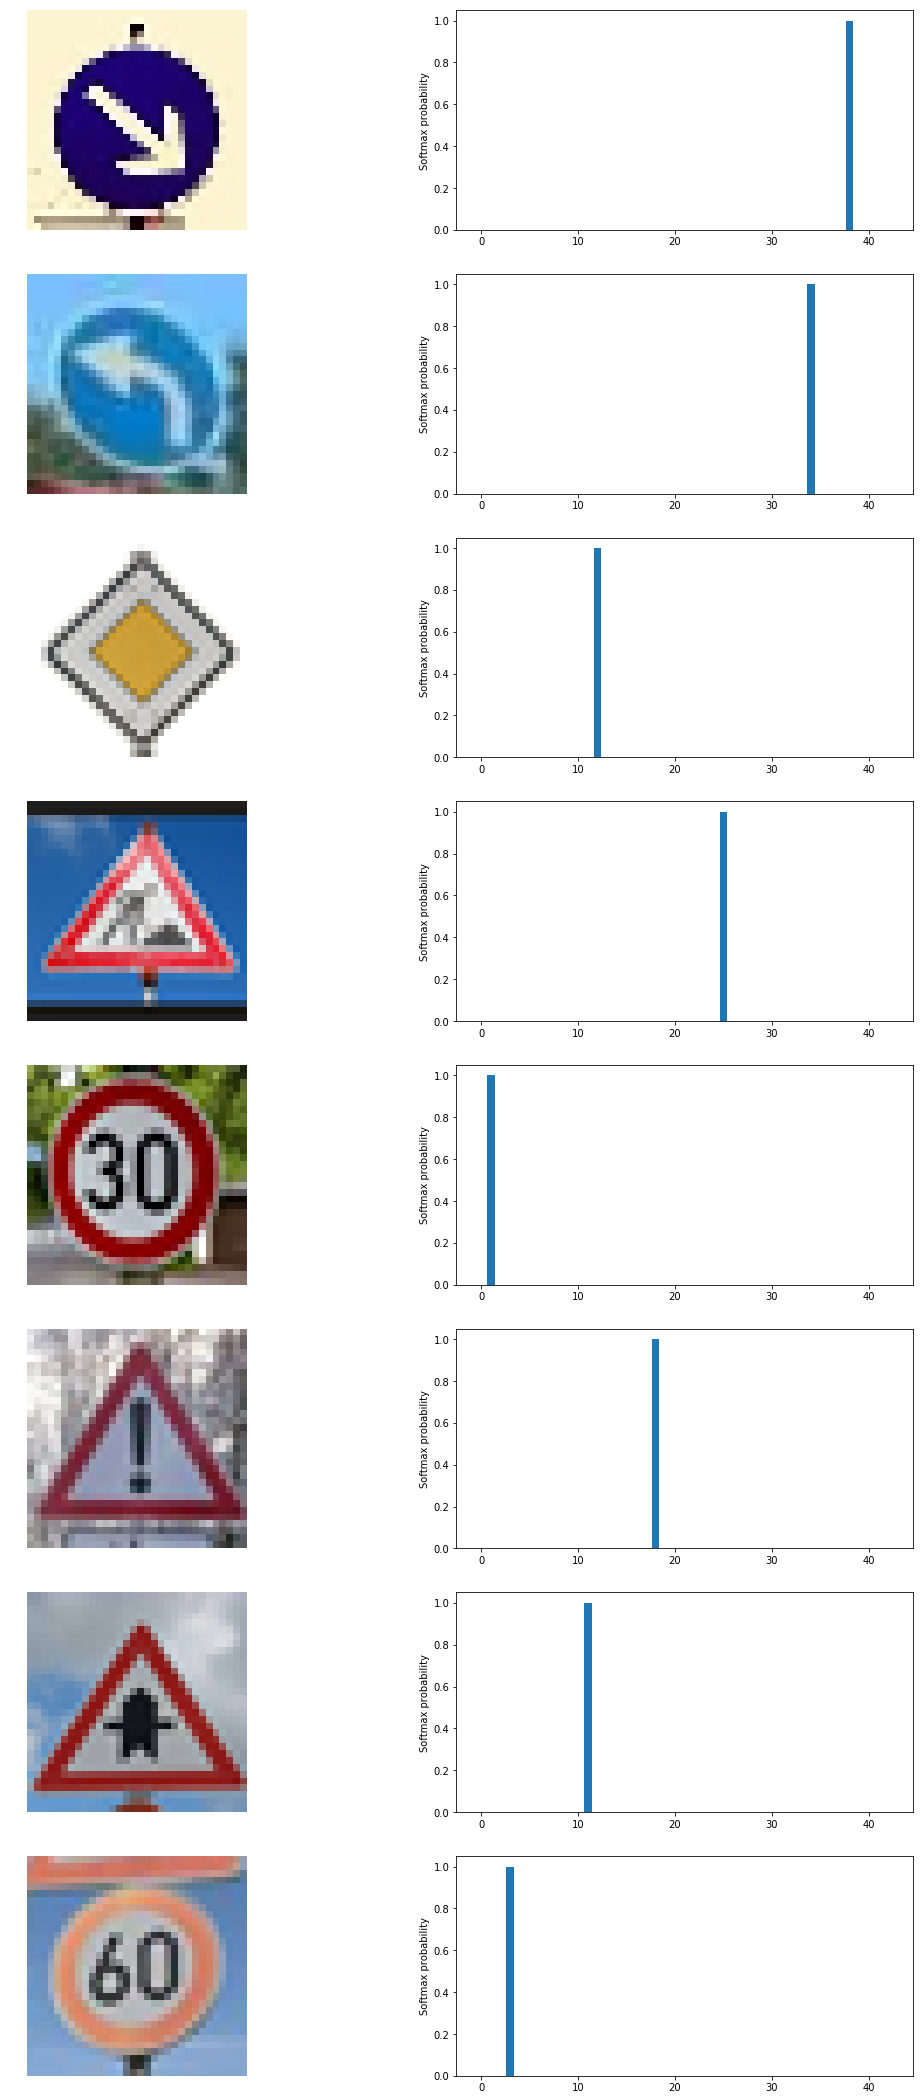

In [24]:
fig, axs = plt.subplots(8,2, figsize=(18, 38))
axs = axs.ravel()

for i in range(len(my_softmax_logits)*2):
    if i%2 == 0:
        axs[i].axis('off')
        axs[i].imshow(cv2.cvtColor(my_images[i//2], cv2.COLOR_BGR2RGB))
    else:
        axs[i].bar(np.arange(n_classes), my_softmax_logits[(i-1)//2]) 
        axs[i].set_ylabel('Softmax probability')

The model is somehow ONE HUNDRED PERCENT certain of 7 out of 8 of the signs I gave it (and it's correct: as you can see further above, I pulled an image for each of the top 3 predicted classes from the original dataset for comparison). Even on the third image, it's 92% certain of its prediction. This very high level of certainty, along with achieving 100% accuracy, on the newly introduced real-world data is indicative of a model that performs very well.